In [5]:
##--------------------------------------##
##                Imports               ##
##--------------------------------------##

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.optim as optim


diamonds_df = pd.read_csv("diamonds.csv")
'''

for downloading the above datset you can refer the following site 
    https://www.kaggle.com/datasets/shivam2503/diamonds 

'''

'\n\nfor downloading the above datset you can refer the following site \n    https://www.kaggle.com/datasets/shivam2503/diamonds \n\n'

In [8]:
##-------------------------------------------##
##              Preprocessing                ##
##-------------------------------------------##

X = diamonds_df.drop('price', axis=1)  
y = diamonds_df['price'].values  

# One-hot encode categorical features, standardize numerical ones
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True,dtype=int)

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X.values, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
##-------------------------------------------##
##             Model building                ##
##-------------------------------------------##

class RegressionNet(nn.Module):
    def __init__(self, num_features):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    

##-------------------------------------------##
##           Optimizer defining              ##
##-------------------------------------------##

class ModifiedAdam(torch.optim.Optimizer):
    def __init__(self, params, lr=0.003, beta1=0.45, beta2=0.92, eps=1e-8):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super(ModifiedAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['v'] = torch.zeros_like(p.data)
                    state['k'] = torch.zeros_like(p.data)

                v, k = state['v'], state['k']
                beta1, beta2, eps, lr = group['beta1'], group['beta2'], group['eps'], group['lr']

                v.mul_(beta1).add_(grad, alpha=1 - beta1)
                k.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                lookahead_grad = grad - beta1 * v
                p.data.addcdiv_(lookahead_grad, torch.sqrt(k) + eps, value=-lr)

        return loss


In [10]:
##-------------------------------------------##
##        Training model function            ##
##-------------------------------------------##

def train_model_with_metrics(model, optimizer, train_loader, val_loader, test_loader, num_epochs=50):
    criterion = nn.MSELoss()
    train_losses, val_losses, test_losses = [], [], []
    val_mae_list, val_rmse_list, test_mae_list, test_rmse_list = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / len(train_loader))

        # Validation phase
        model.eval()
        running_val_loss, running_test_loss = 0.0, 0.0
        all_val_targets, all_val_preds = [], []
        all_test_targets, all_test_preds = [], []
        
        with torch.no_grad():
            # Validation
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                all_val_targets.extend(targets.cpu().numpy())
                all_val_preds.extend(outputs.cpu().numpy())
            
            # Test
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_test_loss += loss.item()
                all_test_targets.extend(targets.cpu().numpy())
                all_test_preds.extend(outputs.cpu().numpy())
        
        val_losses.append(running_val_loss / len(val_loader))
        test_losses.append(running_test_loss / len(test_loader))
        
        # Compute MAE and RMSE
        val_preds_np = np.array(all_val_preds).flatten()
        val_targets_np = np.array(all_val_targets).flatten()
        test_preds_np = np.array(all_test_preds).flatten()
        test_targets_np = np.array(all_test_targets).flatten()

        val_mae = np.mean(np.abs(val_preds_np - val_targets_np))
        val_rmse = np.sqrt(np.mean((val_preds_np - val_targets_np) ** 2))
        test_mae = np.mean(np.abs(test_preds_np - test_targets_np))
        test_rmse = np.sqrt(np.mean((test_preds_np - test_targets_np) ** 2))
        
        val_mae_list.append(val_mae)
        val_rmse_list.append(val_rmse)
        test_mae_list.append(test_mae)
        test_rmse_list.append(test_rmse)

    return train_losses, val_losses, test_losses, val_mae_list, val_rmse_list, test_mae_list, test_rmse_list
def create_optimizer(opt_name, model):
    if opt_name == "ModifiedAdam":
        return ModifiedAdam(model.parameters())
    elif opt_name == "Adam":
        return optim.Adam(model.parameters())
    elif opt_name == "RMSprop":
        return optim.RMSprop(model.parameters())
    

In [11]:
##-------------------------------------------##
##              Training model               ##
##-------------------------------------------##

optimizers = ["ModifiedAdam", "Adam", "RMSprop"]
num_epochs = 30
results = {}

for opt_name in optimizers:
    model = RegressionNet(num_features=X_train.shape[1])  # Adjust based on the dataset feature count
    optimizer = create_optimizer(opt_name, model)  # Use create_optimizer function
    train_losses, val_losses, test_losses, val_mae, val_rmse, test_mae, test_rmse = train_model_with_metrics(
        model, optimizer, train_loader, val_loader, test_loader, num_epochs=num_epochs)
    results[opt_name] = {
        'train_loss': train_losses, 
        'val_loss': val_losses,
        'test_loss': test_losses,
        'val_mae': val_mae,
        'val_rmse': val_rmse,
        'test_mae': test_mae,
        'test_rmse': test_rmse
    }
    print(f"{opt_name} training completed.")

ModifiedAdam training completed.
Adam training completed.
RMSprop training completed.


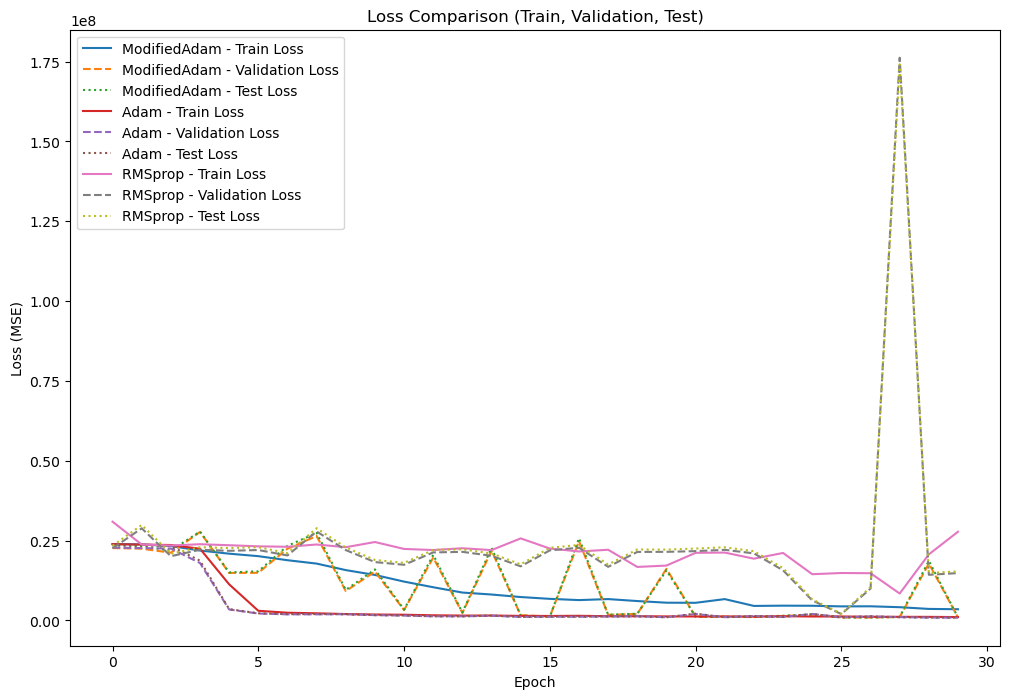

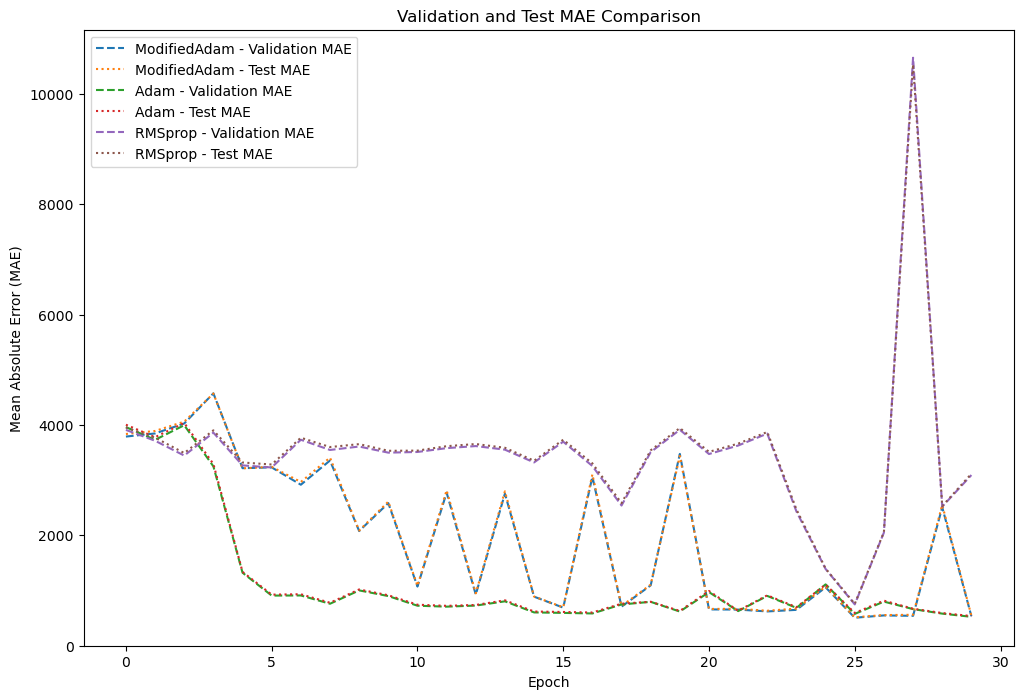

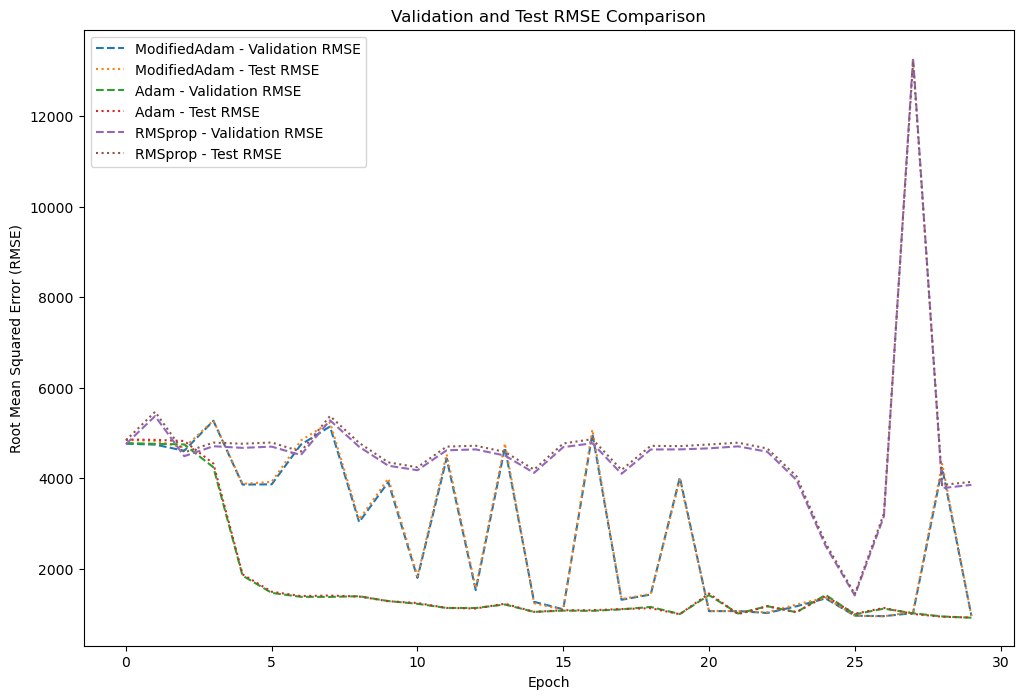

In [12]:
##-------------------------------------------##
##                 Plotting                  ##
##-------------------------------------------##

# Plot Training, Validation, and Test Losses
plt.figure(figsize=(12, 8))
for opt_name, metrics in results.items():
    plt.plot(metrics['train_loss'], label=f"{opt_name} - Train Loss")
    plt.plot(metrics['val_loss'], label=f"{opt_name} - Validation Loss", linestyle='--')
    plt.plot(metrics['test_loss'], label=f"{opt_name} - Test Loss", linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Loss Comparison (Train, Validation, Test)")
plt.legend()
plt.show()

# Plot Validation and Test MAE
plt.figure(figsize=(12, 8))
for opt_name, metrics in results.items():
    plt.plot(metrics['val_mae'], label=f"{opt_name} - Validation MAE", linestyle='--')
    plt.plot(metrics['test_mae'], label=f"{opt_name} - Test MAE", linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Validation and Test MAE Comparison")
plt.legend()
plt.show()

# Plot Validation and Test RMSE
plt.figure(figsize=(12, 8))
for opt_name, metrics in results.items():
    plt.plot(metrics['val_rmse'], label=f"{opt_name} - Validation RMSE", linestyle='--')
    plt.plot(metrics['test_rmse'], label=f"{opt_name} - Test RMSE", linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Validation and Test RMSE Comparison")
plt.legend()
plt.show()

In [13]:
##-------------------------------------------##
##                 Summary                   ##
##-------------------------------------------##

# Print final metrics for each optimizer
for opt_name, metrics in results.items():
    print(f"\n{opt_name} - Final Metrics")
    print(f"Min Training Loss: {min(metrics['train_loss']):.4f}")
    print(f"Min Validation Loss: {min(metrics['val_loss']):.4f}")
    print(f"Min Test Loss: {min(metrics['test_loss']):.4f}")
    print(f"Best Validation MAE: {min(metrics['val_mae']):.4f}")
    print(f"Best Validation RMSE: {min(metrics['val_rmse']):.4f}")
    print(f"Best Test MAE: {min(metrics['test_mae']):.4f}")
    print(f"Best Test RMSE: {min(metrics['test_rmse']):.4f}")


ModifiedAdam - Final Metrics
Min Training Loss: 3505055.3430
Min Validation Loss: 915153.4289
Min Test Loss: 901245.1427
Best Validation MAE: 505.8087
Best Validation RMSE: 954.4740
Best Test MAE: 513.8735
Best Test RMSE: 949.4379

Adam - Final Metrics
Min Training Loss: 1055097.0500
Min Validation Loss: 846389.3119
Min Test Loss: 852978.3754
Best Validation MAE: 521.8421
Best Validation RMSE: 919.5242
Best Test MAE: 535.8083
Best Test RMSE: 923.2671

RMSprop - Final Metrics
Min Training Loss: 8426292.1466
Min Validation Loss: 1993626.3127
Min Test Loss: 2091954.5669
Best Validation MAE: 747.7386
Best Validation RMSE: 1411.2067
Best Test MAE: 756.4214
Best Test RMSE: 1443.1962
